# Libraries

In [27]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Setup

In [28]:
plt.rcParams.update({'font.size': 20})

In [ ]:
# Load test dataset
df_test = pd.read_parquet("../data/final/test_data.parquet")

# Drop classification target to avoid leakage
df_test = df_test.drop(columns=['DepDel15'])

# Extract features and target
X_test = df_test.drop(columns=['DepDelayMinutes'])
y_test = df_test['DepDelayMinutes'].values.ravel()

In [30]:
regression_models_base = {
    "Linear\nRegression (Base)": "../models/lin_reg/lin_reg_base.pkl",
    "SGD (Base)": "../models/sgd_reg/sgd_reg_base.pkl",
    "HGB (Base)": "../models/hgb_reg/hgb_reg_base.pkl",
    "MLP (Base)": "../models/mlp_reg/mlp_reg_base.pkl",
}

regression_models = {
    "Linear\nRegression": "../models/lin_reg/lin_reg_tuned.pkl",
    "SGD": "../models/sgd_reg/sgd_reg_tuned.pkl",
    "HGB": "../models/hgb_reg/hgb_reg_tuned.pkl",
    "MLP": "../models/mlp_reg/mlp_reg_tuned.pkl"
}

# Helper Functions

In [31]:
def reg_evaluater(models_dict, X_test, y_test):
    """Loads regression models, evaluates them, and returns performance metrics."""
    results = []
    predictions = {}

    for model_name, file in models_dict.items():
        with open(file, "rb") as f:
            model = pickle.load(f)

        # Make predictions
        y_pred = model.predict(X_test)
        predictions[model_name] = y_pred

        # Compute evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Model": model_name,
            "RMSE": rmse,
            "MAE": mae,
            "R²": r2
        })

    return pd.DataFrame(results), predictions

In [32]:
def reg_performance_plotter(df_results):
    """Creates separate bar plots for RMSE, MAE, and R² as individual plots without custom colors."""
    metrics = ["RMSE", "MAE", "R²"]

    for metric in metrics:
        plt.figure(figsize=(8, 6))
        df_results.set_index("Model")[metric].plot(kind="bar")
        plt.title(f"Comparison of {metric}")
        plt.ylabel(metric)
        plt.xticks(rotation=360)
        plt.grid()
        plt.show()

In [ ]:
def reg_residuals(model_predictions, y_test):
    """Creates a 2x2 subplot layout for residual plots of regression models."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)  # Sharing axes for better comparison
    model_names = list(model_predictions.keys())

    for i, ax in enumerate(axes.flat):  
        if i < len(model_names):
            model_name = model_names[i]
            residuals = y_test - model_predictions[model_name]

            sns.scatterplot(x=y_test, y=residuals, alpha=0.5, ax=ax)
            ax.axhline(0, color="red", linestyle="--")
            ax.set_title(f"{model_name}")

    # Set global x and y labels
    fig.text(0.5, 0.04, "Actual Values", ha="center", fontsize=24)
    fig.text(0.04, 0.5, "Residuals", va="center", rotation="vertical", fontsize=24)

    # Adjust layout
    plt.suptitle("Residual Plots", fontsize=24)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to accommodate labels
    plt.show()


In [34]:
def reg_permutation_importance(models_dict, X_test, y_test, scoring="r2", n_repeats=5, frac=0.1):
    """Computes permutation importance for regression models with parallel processing.
       Returns a DataFrame with feature importances and a DataFrame of top 5 features per model.
    """
    feature_importances = {}
    top_features = {}

    # Sampling to speed up computation (without stratification, since it's regression)
    if frac < 1.0:
        X_test_sample, _, y_test_sample, _ = train_test_split(
            X_test, y_test, test_size=(1-frac), random_state=42
        )
    else:
        X_test_sample, y_test_sample = X_test, y_test

    for model_name, file in models_dict.items():
        with open(file, "rb") as f:
            model = pickle.load(f)

        # Compute permutation importance
        result = permutation_importance(
            model, X_test_sample, y_test_sample,
            scoring=scoring, n_repeats=n_repeats, random_state=42, n_jobs=-1
        )

        # Store feature importance scores
        feature_importances[model_name] = result.importances_mean

        # Get top 5 features for the current model
        sorted_indices = result.importances_mean.argsort()[::-1][:5]
        top_features[model_name] = X_test.columns[sorted_indices].tolist()

    # Convert to DataFrame
    df_importance = pd.DataFrame(feature_importances, index=X_test.columns)

    # Compute global importance ranking
    df_importance["Mean Importance"] = df_importance.mean(axis=1)
    df_importance["Feature"] = df_importance.index  # Add feature names inside the DataFrame
    df_importance["Rank"] = df_importance["Mean Importance"].rank(ascending=False)

    # Sort by mean importance
    df_importance = df_importance.sort_values(by="Mean Importance", ascending=False)

    # Reorder columns: Rank (as index), Feature, Models..., Mean Importance
    column_order = ["Feature"] + list(models_dict.keys()) + ["Mean Importance"]
    df_importance = df_importance[["Rank"] + column_order]
    
    df_importance.set_index("Rank", inplace=True)  # Set Rank as the index

    # Convert top features dictionary into DataFrame and transpose
    df_top_features = pd.DataFrame.from_dict(top_features, orient='index').T
    df_top_features.index = range(1, 6)  # Ranking from 1 to 5
    df_top_features.index.name = "Rank"  # Set index name to Rank
    
    return df_importance, df_top_features

# Results

### Base Model Results

In [35]:
df_reg_base, reg_preds_base = reg_evaluater(regression_models_base, X_test, y_test)
df_reg_base

,Model,RMSE,MAE,R²
0,Linear\nRegression (Base),73.004914,36.640668,0.060442
1,SGD (Base),73.055094,36.799227,0.059150
2,HGB (Base),72.052887,35.999443,0.084787
3,MLP (Base),72.359746,35.949544,0.076975


### Tuned Model Results

In [36]:
df_reg_tuned, reg_preds_tuned = reg_evaluater(regression_models, X_test, y_test)
df_reg_tuned

,Model,RMSE,MAE,R²
0,Linear\nRegression,73.004914,36.640668,0.060442
1,SGD,73.007339,36.654660,0.060380
2,HGB,71.571922,35.644984,0.096965
3,MLP,72.534901,35.937616,0.072501


## Tuned Model Plots

### Tuned Model Performance Comparison

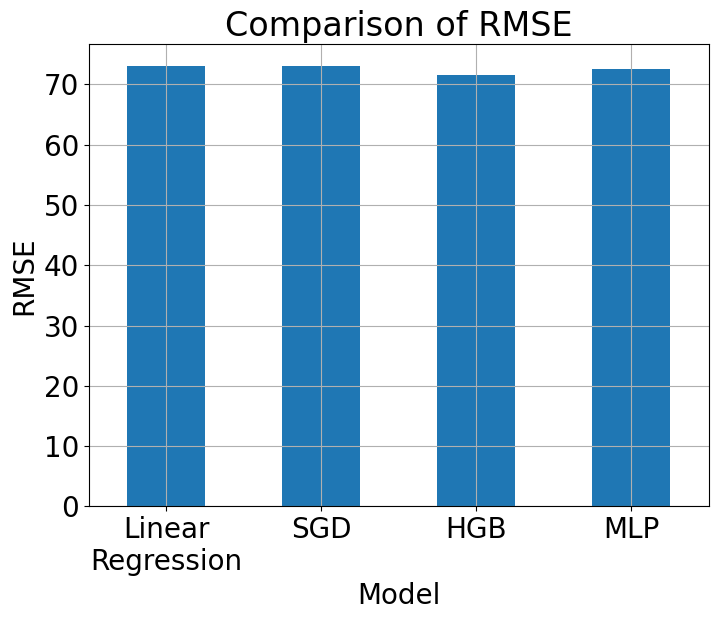

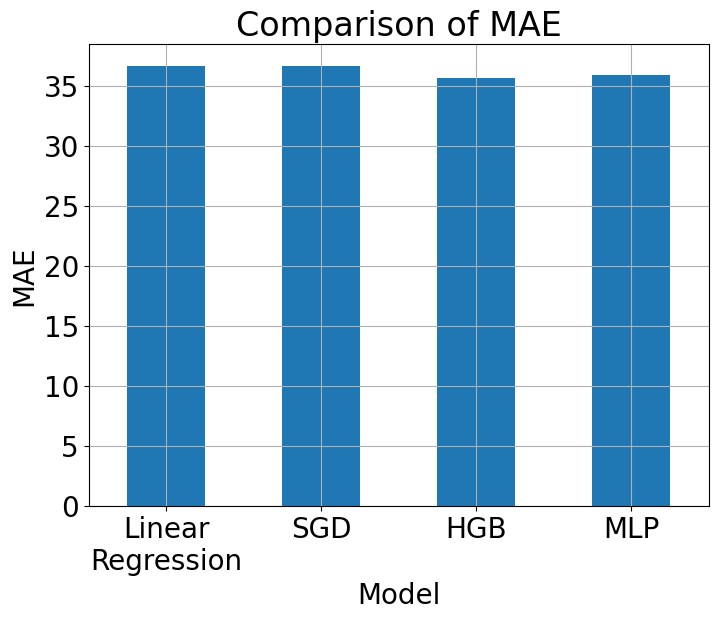

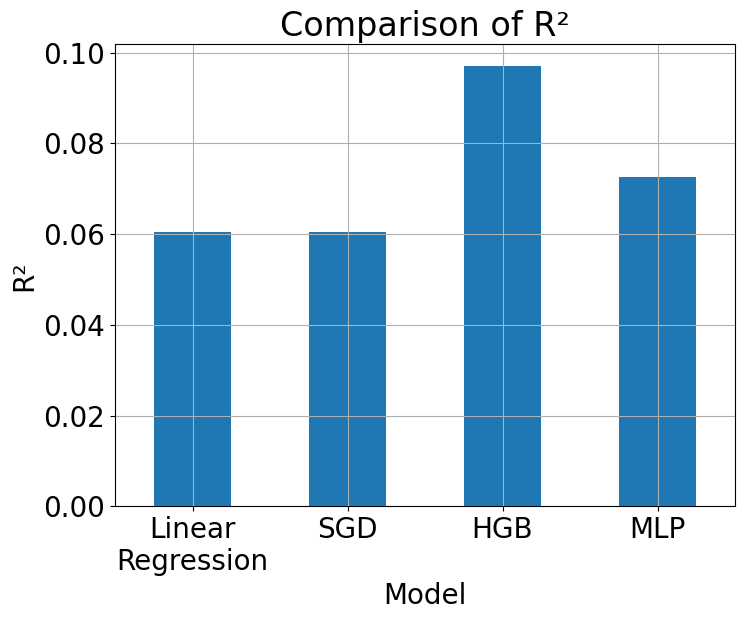

In [37]:
reg_performance_plotter(df_reg_tuned)

### Tuned Model Residual Plots

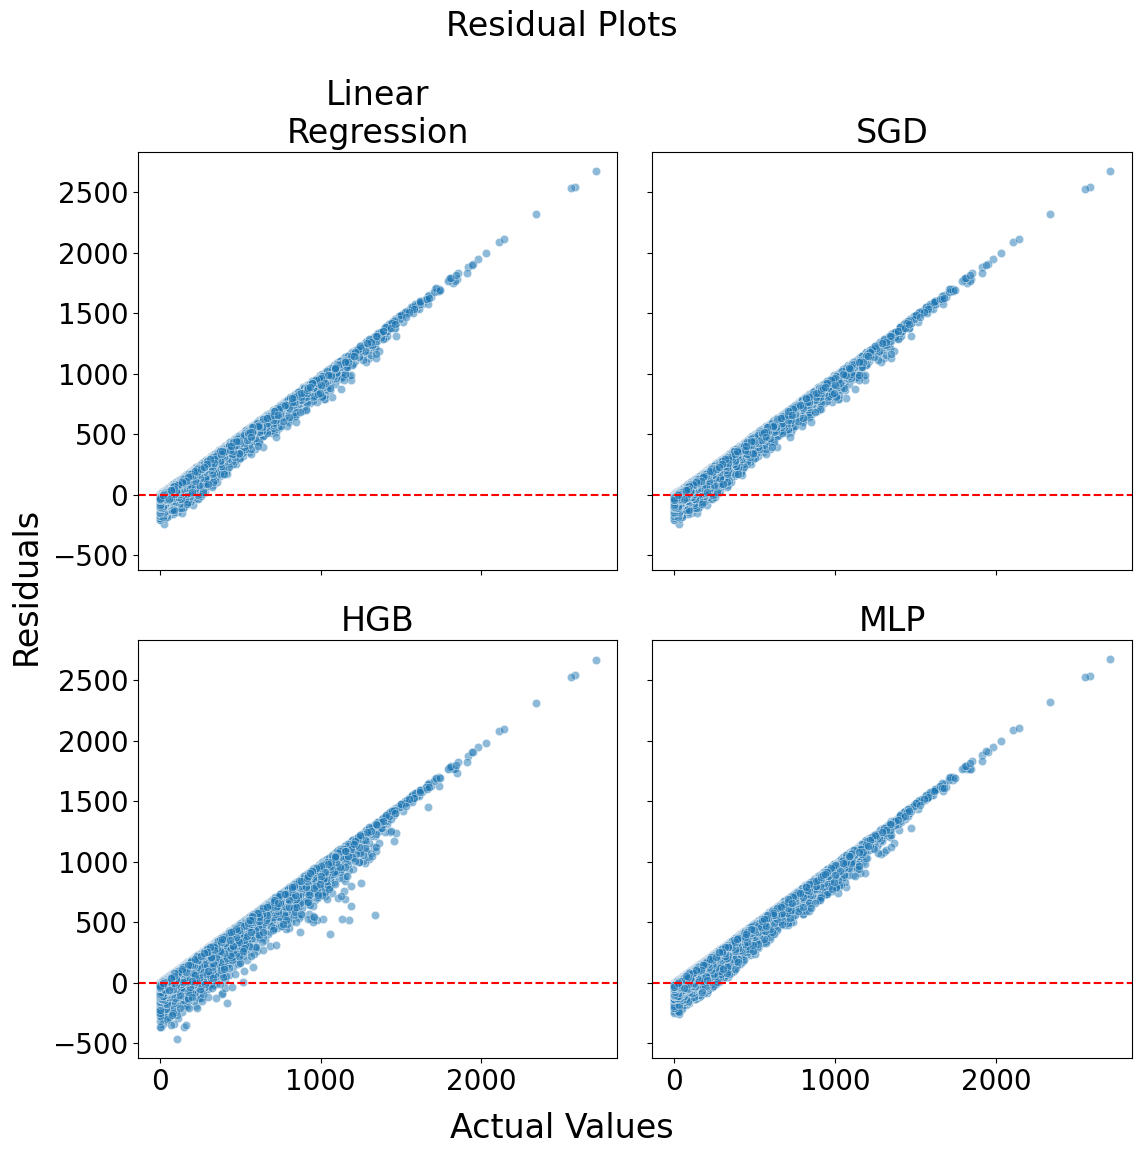

In [40]:
reg_residuals(reg_preds_tuned, y_test)

## Tuned Model Feature Importance

In [76]:
df_reg_feature_importance, df_reg_top_features = reg_permutation_importance(regression_models, X_test, y_test)

In [77]:
df_reg_feature_importance

,Feature,Linear Regression,SGD Regression,HGB Regression,MLP Regression,Mean Importance
Rank,,,,,,
1.0,past_50_avg_delay,0.014696,1.466876e-02,0.021575,0.020353,0.017823
2.0,Distance,0.004393,4.740301e-03,0.029551,0.015946,0.013658
3.0,AirTime,0.004113,4.194223e-03,0.027919,0.015302,0.012882
4.0,past_10_avg_delay,0.011427,1.138732e-02,0.013334,0.012296,0.012111
5.0,CRSDepTime_cos,0.019207,1.319765e-02,0.003465,0.009379,0.011312
...,...,...,...,...,...,...
59.0,Holiday_Indicator,-0.000002,-3.516801e-07,0.000085,0.000121,0.000051
60.0,Working_Day,0.000028,2.562554e-06,0.000013,0.000140,0.000046
61.0,DistanceCategory,0.000017,3.215628e-06,0.000080,0.000026,0.000032


In [79]:
df_reg_top_features

,Linear Regression,SGD Regression,HGB Regression,MLP Regression
Rank,,,,
1,CRSDepTime_cos,past_50_avg_delay,Distance,past_50_avg_delay
2,past_50_avg_delay,CRSDepTime_cos,AirTime,Distance
3,past_10_avg_delay,past_10_avg_delay,past_50_avg_delay,AirTime
4,CRSDepTime,past_100_avg_delay,Airline,past_10_avg_delay
5,past_100_avg_delay,Distance,Dest_PRCP,CRSDepTime_cos
